In [ ]:
!pip install selenium
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
!apt-get update
!apt install chromium-chromedriver
! pip install konlpy
!pip install ujson
!pip install pyLDAvis 
!pip install gensim
! pip install nltk

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import requests
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup
import time
from time import sleep
import random


# Data Preprocessing Package
import re                       #정규식
import numpy as np
import pandas as pd
import os                      #디렉토리와 경로정보

# NLP Package
from konlpy.tag import * 
import gensim                    #토픽모델링을 하는 라이브러리
import gensim.corpora as corpora #텍스트분석
from gensim.models import CoherenceModel
from collections import Counter
import nltk

# Visualization Package   
import pyLDAvis 
import pyLDAvis.gensim_models 
import warnings
warnings.filterwarnings("ignore")
import matplotlib as mpl
from matplotlib import font_manager
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline
plt.rc('font', family='NanumBarunGothic')

from PIL import Image
plt.rcParams['font.family'] = 'NanumGothic'
mpl.matplotlib_fname()
%config InlineBackend.figure_format = 'retina'
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
from pprint import pprint #pretty print
import itertools #iterable 객체 처리
import math

import logging #로그처리
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
 
import warnings #경고 무시
warnings.filterwarnings("ignore",category=DeprecationWarning)

pd.set_option('display.max_rows', 200)

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [ ]:
# 파일 업로드
import shutil
try:
  shutil.copy("/content/drive/MyDrive/텍데분/toss_dataset.zip", '/content/')
  print('dataset download!!!')
except Exception as err:
  print(str(err))

# 압축 풀고 디렉토리 생성
import zipfile

with zipfile.ZipFile('/content/toss_dataset.zip', 'r') as target_file:
    target_file.extractall('/content/dataset/')
print('ok')

dataset download!!!
ok


In [ ]:
# 기본 저장 주소
ROOT_PATH ="./dataset/toss_dataset"
# 데이터 저장 주소(high)
DATA_FOLDER_PATH = os.path.join(ROOT_PATH,"1.Data/")
DATA_FILE_NAME = os.path.join(DATA_FOLDER_PATH,"highreview.xlsx")                  
DATA_STOP_WORD_FILE_NAME = os.path.join(DATA_FOLDER_PATH,"Data_stop_word.txt")   # 불용어 사전 

# 모델 저장 주소
MODEL_SAVE_FOLDER = os.path.join(ROOT_PATH,"2.Model/")
LDA_MODEL_SAVE_NAME = os.path.join(MODEL_SAVE_FOLDER, "Model_lda_topic_modeling.lda")
OPT_MODEL_SAVE_NAME = os.path.join(MODEL_SAVE_FOLDER, "Model_opt_topic_modeling.lda")

# 결과물 저장 주소
RESULT_FOLDER = os.path.join(ROOT_PATH,"3.Result/")
RESULT_SAVE_LDAVIS = os.path.join(RESULT_FOLDER,"Result_lda_vis.html")
RESULT_TOPIC_EXCEL = os.path.join(RESULT_FOLDER,"Result_topic_excel.xlsx")
RESULT_corpus_EXCEL = os.path.join(RESULT_FOLDER,"Result_corpus_excel.xlsx")



> # 데이터 불러오기



In [ ]:
# 데이터 불러오기 
DF_high = pd.read_csv("/content/drive/MyDrive/텍데분/토스리뷰_상위.txt") 
print(len(DF_high))

# 불러온 데이터의 값이 비어 있는지 확인
print('Null값이 있는지 확인합니다.',DF_high.isnull().values.any()) # Null 값이 존재하는지 확인 (False=정상)
print('')
DF_high = DF_high.dropna(how = 'any') # Null 값이 존재하는 행 제거
print("고유리뷰수:", DF_high["리뷰"].nunique())
print('')
DF_high = DF_high.drop_duplicates()   # 중복 데이터 프레임 제거 
DF_high = DF_high.reset_index(drop=True) # 데이터 프레임 재색인
print('중복 및, NULL값을 제거한 후, 다시 NULL값을 확인 합니다.', DF_high.isnull().values.any()) # Null 값이 존재하는지 확인 (False=정상)
print('')
print("처리할 데이터수 : ",)

# 데이터 불러오기 
DF_low = pd.read_csv("/content/drive/MyDrive/텍데분/토스리뷰_하위.txt") 
print(len(DF_low))

# 불러온 데이터의 값이 비어 있는지 확인
print('Null값이 있는지 확인합니다.',DF_low.isnull().values.any()) # Null 값이 존재하는지 확인 (False=정상)
print('')
DF_low = DF_low.dropna(how = 'any') # Null 값이 존재하는 행 제거
print("고유리뷰수:", DF_low['리뷰'].nunique())
print('')
DF_low = DF_low.drop_duplicates()   # 중복 데이터 프레임 제거 
DF_low = DF_low.reset_index(drop=True) # 데이터 프레임 재색인
print('중복 및, NULL값을 제거한 후, 다시 NULL값을 확인 합니다.', DF_low.isnull().values.any()) # Null 값이 존재하는지 확인 (False=정상)
print('')
print("처리할 데이터수 : ",)

DF_low

266
Null값이 있는지 확인합니다. True

고유리뷰수: 133

중복 및, NULL값을 제거한 후, 다시 NULL값을 확인 합니다. False

처리할 데이터수 : 
134
Null값이 있는지 확인합니다. True

고유리뷰수: 67

중복 및, NULL값을 제거한 후, 다시 NULL값을 확인 합니다. False

처리할 데이터수 : 


,리뷰
0,"업데이트 후 해외사용, 인증불가/ 안녕하세요. 토스를 몇 년 째 잘 사용해오고 있습..."
1,토스 질사용하고잇습니다. 한가지 불편한점이 잇어서 글남김니다. 다름이 아닌 만보기에...
2,미션을 바꾸겠읍니까? 미션을 바꾸겠읍니까? 미션을 바꾸겠읍니까? 도데체 뭘 자꾸 미...
3,건의사항 송금을 한다거나 이자를 받을때 발생하는 본인확인하는 기능을 횟수를 줄여 주...
4,"토스 잘 쓰고 있습니다. 한 가지 아쉬운게, 자산 편집 기능이 온전히 자유롭게 되지..."
5,너무 잘 이용하고 있는데 한가지 개선해주셨으면 하는 사항이 있어서 글 남겨요 토스뱅...
6,"이번 달 사용 금액을 확인하는데, 제가 지출하지 않은 내역이 떠있습니다. 해당 내역..."
7,연금저축이 뜨네요! 그런데 연금탭에 안가고 투자탭에 있더라고요 그래서 옮기고 싶은데...
8,다음달 낼 카드값 보여주는 기능 아주 좋습니다! 모든 카드를 다 합산해서 보여주니 ...
9,기변하고 앱을 새로 등록하는 과정에서 정보를 입력 하라길래 앱을 변경한 기기에서 다...


In [ ]:
#하위 상위 데이터프레임 합치기
temp=pd.concat([DF_low['리뷰'],DF_high['리뷰']]).reset_index()
temp = temp.drop(['index'],axis=1)



> # 토크나이징(Tokenizing)



In [ ]:
tokenizer = Twitter() # 토큰나이저 지정
stopword_vocab = DATA_STOP_WORD_FILE_NAME # 불용어 파일 불러오기
sep = "\n" # 불용어 처리 인자

def build_vocab(data_frame,stopword_vocab, separate):
    
    # 불용어 데이터를 가져와 리스트로 변환합니다.
    with open(stopword_vocab, encoding = 'utf-8') as f:
        temp1 = []
        for i in f:
            temp1.append(i)
            
    globals()['stopword_vocab'] = []
    
    # 불용어 데이터는 전역변수 stopword_vocab 선언합니다. 
    # 구분자에 따라 stopword_vocab에 추가하여 불용어 사전을 구축합니다.
    for j in range(len(temp1)):
        temp2 = temp1[j].rstrip(separate)
        globals()['stopword_vocab'].append(temp2)
    
    #품사를 달고 token을 출력합니다.
    globals()['list_sent2words'] =[]
    for i in range(len(data_frame)) :
        num_list=[]
        temp = tokenizer.pos(data_frame[i])
        for j in range(len(temp)):
            num_list.append(temp[j])
        globals()['list_sent2words'].append(num_list)

    return [[word for word in doc if word not in globals()['stopword_vocab']] for doc in globals()['list_sent2words']]

result_data =build_vocab(temp['리뷰'],stopword_vocab, sep)

In [ ]:
#얻은 토큰에서 명사, 형용사만 가져오기
newL=[]
N_POS = ['Noun']  
V_POS = ['Adjective']  
for n in range(len(result_data)):
    temp = []
    for k in result_data[n]:
        if k[1] in V_POS:
            temp.append(k[0])
        elif k[1] in N_POS:
            temp.append(k[0])
    newL.append(temp)
print(newL)

[['업데이트', '후', '해외', '사용', '인증', '불가', '안녕하세요', '토스', '몇', '년', '사용', '있습니다', '이민', '후', '이번', '한국', '잠시', '때', '한국', '폰', '번호', '다시', '여태', '사용', '번호', '업데이트', '이후', '한국', '번호', '없어서', '인증', '수', '없습니다', '한국', '카드', '있지만', '수', '있는', '전화번호', '없구요', '주식', '모든', '걸', '거기', '이용', '방법', '있을까요'], ['토스', '질', '사용', '한가지', '불편한', '점', '글', '다름이', '아닌', '보기', '실제', '곳', '거리', '다르게', '때', '있습니다', '이점', '조금', '불편하고', '점', '좋습니다'], ['미션', '읍', '미션', '읍', '미션', '읍', '도데', '체', '뭘', '자꾸', '미션', '읍', '글자', '토시', '하나', '미션', '읍', '장난', '질도', '정도', '껏', '아니고', '몇번', '똑같은', '리뷰', '개선', '하든', '개선', '생각', '있는지', '의문', '해당', '미션', '완려', '외', '미션', '한글', '컴퓨터', '답변', '달', '기전', '토시', '하나', '분명히', '리뷰', '놨는데', '일부러', '열', '답변'], ['건의', '사항', '송금', '이자', '때', '발생', '본인', '확인', '기능', '횟수', '보통', '이자', '다른', '통장', '수순', '그때', '마다', '매번', '본인', '확인', '비번', '번거로워요', '보안', '생각', '본인', '확인', '이해', '번거롭습니다', '시간', '본인', '확인', '연장', '더', '편리하고', '좋을', '것', '같아요'], ['토스', '있습니다', '가지', '아쉬운게', '자산', '편집', '기능', '자유롭

In [ ]:
#불용어 제거
def remove_stopwords(text):
    temp2 = []
    for j in range(len(text)) : 
        meaningful_words = [w for w in text[j] if not w in stopword_vocab]
        temp2.append(meaningful_words)
    return temp2

finalL=remove_stopwords(newL)

#길이가 1이상인 단어만 가져오기
num_list = []
for j in range(len(finalL)):
    temp = []
    for k in range(len(finalL[j])):
        if len(finalL[j][k]) > 1:
            temp.append(finalL[j][k])
    num_list.append(temp)

print(num_list)

[['업데이트', '해외', '인증', '불가', '안녕하세요', '있습니다', '이민', '한국', '잠시', '한국', '번호', '여태', '번호', '업데이트', '한국', '번호', '없어서', '인증', '없습니다', '한국', '카드', '있지만', '있는', '전화번호', '없구요', '주식', '모든', '거기', '이용', '방법', '있을까요'], ['불편한', '다름이', '아닌', '실제', '거리', '다르게', '있습니다', '이점', '조금', '불편하고', '좋습니다'], ['미션', '미션', '미션', '도데', '자꾸', '미션', '글자', '토시', '미션', '장난', '질도', '정도', '아니고', '똑같은', '리뷰', '개선', '하든', '개선', '있는지', '의문', '미션', '완려', '미션', '한글', '컴퓨터', '기전', '토시', '분명히', '리뷰', '놨는데', '일부러'], ['건의', '송금', '이자', '발생', '기능', '횟수', '보통', '이자', '수순', '마다', '매번', '비번', '번거로워요', '보안', '이해', '번거롭습니다', '시간', '연장', '편리하고', '좋을', '같아요'], ['있습니다', '아쉬운게', '자산', '편집', '기능', '자유롭게', '일반', '계좌', '더라도', '연금', '저축', '펀드', '계좌', '연금탭', '투자탭', '없다든', '문제', '있습니다', '이용자', '편의', '위해', '이용자', '원하는', '대로', '편집', '허용'], ['이용', '있는데', '개선', '있어서', '뱅크', '자산', '숨기', '은행', '계좌', '기능', '가능한데', '뱅크', '기별', '기능', '없어서', '모두', '집계', '기별', '기능', '좋겠습니다'], ['금액', '지출', '결제', '수단', '등록', '은행', '계좌', '거래', '조회', '실제', '계좌', '금액', '없구요', 

In [ ]:
#추가 불용어제거
stopword = ['있습니다','입니다','있어요','있어서','있는','같아요','같습니다','있으나','있으면']
LL=[]
for j in range(len(num_list)):
    temp = [i for i in num_list[j] if i not in stopword]
    LL.append(temp)
print(LL)

[['업데이트', '해외', '인증', '불가', '안녕하세요', '이민', '한국', '잠시', '한국', '번호', '여태', '번호', '업데이트', '한국', '번호', '없어서', '인증', '없습니다', '한국', '카드', '있지만', '전화번호', '없구요', '주식', '모든', '거기', '이용', '방법', '있을까요'], ['불편한', '다름이', '아닌', '실제', '거리', '다르게', '이점', '조금', '불편하고', '좋습니다'], ['미션', '미션', '미션', '도데', '자꾸', '미션', '글자', '토시', '미션', '장난', '질도', '정도', '아니고', '똑같은', '리뷰', '개선', '하든', '개선', '있는지', '의문', '미션', '완려', '미션', '한글', '컴퓨터', '기전', '토시', '분명히', '리뷰', '놨는데', '일부러'], ['건의', '송금', '이자', '발생', '기능', '횟수', '보통', '이자', '수순', '마다', '매번', '비번', '번거로워요', '보안', '이해', '번거롭습니다', '시간', '연장', '편리하고', '좋을'], ['아쉬운게', '자산', '편집', '기능', '자유롭게', '일반', '계좌', '더라도', '연금', '저축', '펀드', '계좌', '연금탭', '투자탭', '없다든', '문제', '이용자', '편의', '위해', '이용자', '원하는', '대로', '편집', '허용'], ['이용', '있는데', '개선', '뱅크', '자산', '숨기', '은행', '계좌', '기능', '가능한데', '뱅크', '기별', '기능', '없어서', '모두', '집계', '기별', '기능', '좋겠습니다'], ['금액', '지출', '결제', '수단', '등록', '은행', '계좌', '거래', '조회', '실제', '계좌', '금액', '없구요', '이런', '오류', '발생', '건가', '체크카드', '후불', '결제', '아닙니다', 

In [ ]:
from collections import Counter
vocab = Counter(k)
print(vocab)
vocab_size = len(k)
print(vocab_size)
vocab = vocab.most_common(5) # 등장 빈도수가 높은 상위 n개의 단어만 저장 vocab
print(vocab)

Counter({'인증': 2, '미션': 2, '업데이트': 1, '해외': 1, '한국': 1, '번호': 1, '없어서': 1, '불편하고': 1, '좋습니다': 1, '완려': 1, '한글': 1, '일부러': 1, '건의': 1, '번거로워요': 1, '보안': 1, '이해': 1, '번거롭습니다': 1, '편리하고': 1, '좋을': 1})
21
[('인증', 2), ('미션', 2), ('업데이트', 1), ('해외', 1), ('한국', 1)]


In [ ]:
# 전체 에 대한 워드 카운트 계수 확인

def word_corpus(result_data):
    #전체 단어의 갯수 파악
    words = list(itertools.chain(*result_data))
    print('전체 워드의 개수 : {}'.format(len(words)))

    #단어의 빈도수를 확인 후 추가할 불용어 확인 작업
    vocab = Counter(words)
    vocab_size = len(words)
    vocab = vocab.most_common(vocab_size) # 등장 빈도수가 높은 상위 n개의 단어만 저장 vocab
    return vocab

vocab=word_corpus(LL)
print(vocab)
# 전체 워드의 빈도 계수 
df_corpus=pd.DataFrame(columns=["text","count"])
tmp_list=[]
tmp_list1=[]
for word, num in vocab:
    tmp_list.append(word)
    tmp_list1.append(num)
df_corpus['text']=tmp_list
df_corpus['count']=tmp_list1
#상위 20개의 워드 카운드 계수만 출력
a=df_corpus.head(1000)
print(df_corpus.head(20))

#빈도분석한 결과를 별도의 파일에 저장함
a.to_excel(RESULT_corpus_EXCEL ,sheet_name = "sheet2low")


전체 워드의 개수 : 4442
[('기능', 97), ('계좌', 75), ('업데이트', 56), ('송금', 44), ('카드', 39), ('주식', 39), ('추가', 32), ('은행', 31), ('개선', 28), ('소비', 28), ('이용', 27), ('입력', 27), ('포인트', 26), ('설정', 25), ('증권', 25), ('인증', 24), ('데이터', 24), ('문제', 21), ('자동', 21), ('좋겠습니다', 20), ('결제', 20), ('메모', 20), ('연결', 19), ('금액', 18), ('같은', 18), ('인증서', 18), ('버튼', 18), ('조회', 17), ('이체', 17), ('좋겠어요', 17), ('잔액', 17), ('연동', 16), ('불편합니다', 16), ('사람', 16), ('수수료', 16), ('가계부', 16), ('자산', 15), ('있는데', 15), ('지출', 15), ('한번', 15), ('출금', 15), ('화면', 15), ('최근', 14), ('해외', 13), ('뱅크', 13), ('있어', 13), ('관리', 13), ('좋은', 13), ('입출금', 13), ('알림', 13), ('조금', 12), ('있고', 12), ('카테고리', 12), ('표시', 12), ('종목', 12), ('미션', 11), ('좋을', 11), ('편집', 11), ('빠른', 11), ('정보', 11), ('부탁드립니다', 11), ('예전', 11), ('서비스', 11), ('내용', 11), ('관심', 11), ('모든', 10), ('정도', 10), ('시간', 10), ('등록', 10), ('오류', 10), ('채팅', 10), ('있게', 10), ('어떻게', 10), ('실행', 10), ('번호', 9), ('좋습니다', 9), ('건의', 9), ('거래', 9), ('좋은데', 9), ('기기', 9), 



> # 단어 빈도수 시각화




In [ ]:
#한 리스트에 담아주기
title = []
for n in range(len(LL)):
    for word in LL[n] :
        title.append(word)
title

['업데이트',
 '해외',
 '인증',
 '불가',
 '안녕하세요',
 '이민',
 '한국',
 '잠시',
 '한국',
 '번호',
 '여태',
 '번호',
 '업데이트',
 '한국',
 '번호',
 '없어서',
 '인증',
 '없습니다',
 '한국',
 '카드',
 '있지만',
 '전화번호',
 '없구요',
 '주식',
 '모든',
 '거기',
 '이용',
 '방법',
 '있을까요',
 '불편한',
 '다름이',
 '아닌',
 '실제',
 '거리',
 '다르게',
 '이점',
 '조금',
 '불편하고',
 '좋습니다',
 '미션',
 '미션',
 '미션',
 '도데',
 '자꾸',
 '미션',
 '글자',
 '토시',
 '미션',
 '장난',
 '질도',
 '정도',
 '아니고',
 '똑같은',
 '리뷰',
 '개선',
 '하든',
 '개선',
 '있는지',
 '의문',
 '미션',
 '완려',
 '미션',
 '한글',
 '컴퓨터',
 '기전',
 '토시',
 '분명히',
 '리뷰',
 '놨는데',
 '일부러',
 '건의',
 '송금',
 '이자',
 '발생',
 '기능',
 '횟수',
 '보통',
 '이자',
 '수순',
 '마다',
 '매번',
 '비번',
 '번거로워요',
 '보안',
 '이해',
 '번거롭습니다',
 '시간',
 '연장',
 '편리하고',
 '좋을',
 '아쉬운게',
 '자산',
 '편집',
 '기능',
 '자유롭게',
 '일반',
 '계좌',
 '더라도',
 '연금',
 '저축',
 '펀드',
 '계좌',
 '연금탭',
 '투자탭',
 '없다든',
 '문제',
 '이용자',
 '편의',
 '위해',
 '이용자',
 '원하는',
 '대로',
 '편집',
 '허용',
 '이용',
 '있는데',
 '개선',
 '뱅크',
 '자산',
 '숨기',
 '은행',
 '계좌',
 '기능',
 '가능한데',
 '뱅크',
 '기별',
 '기능',
 '없어서',
 '모두',
 '집계',
 '기별',
 '기능',
 '좋겠습니다',
 '금액',
 '지출'

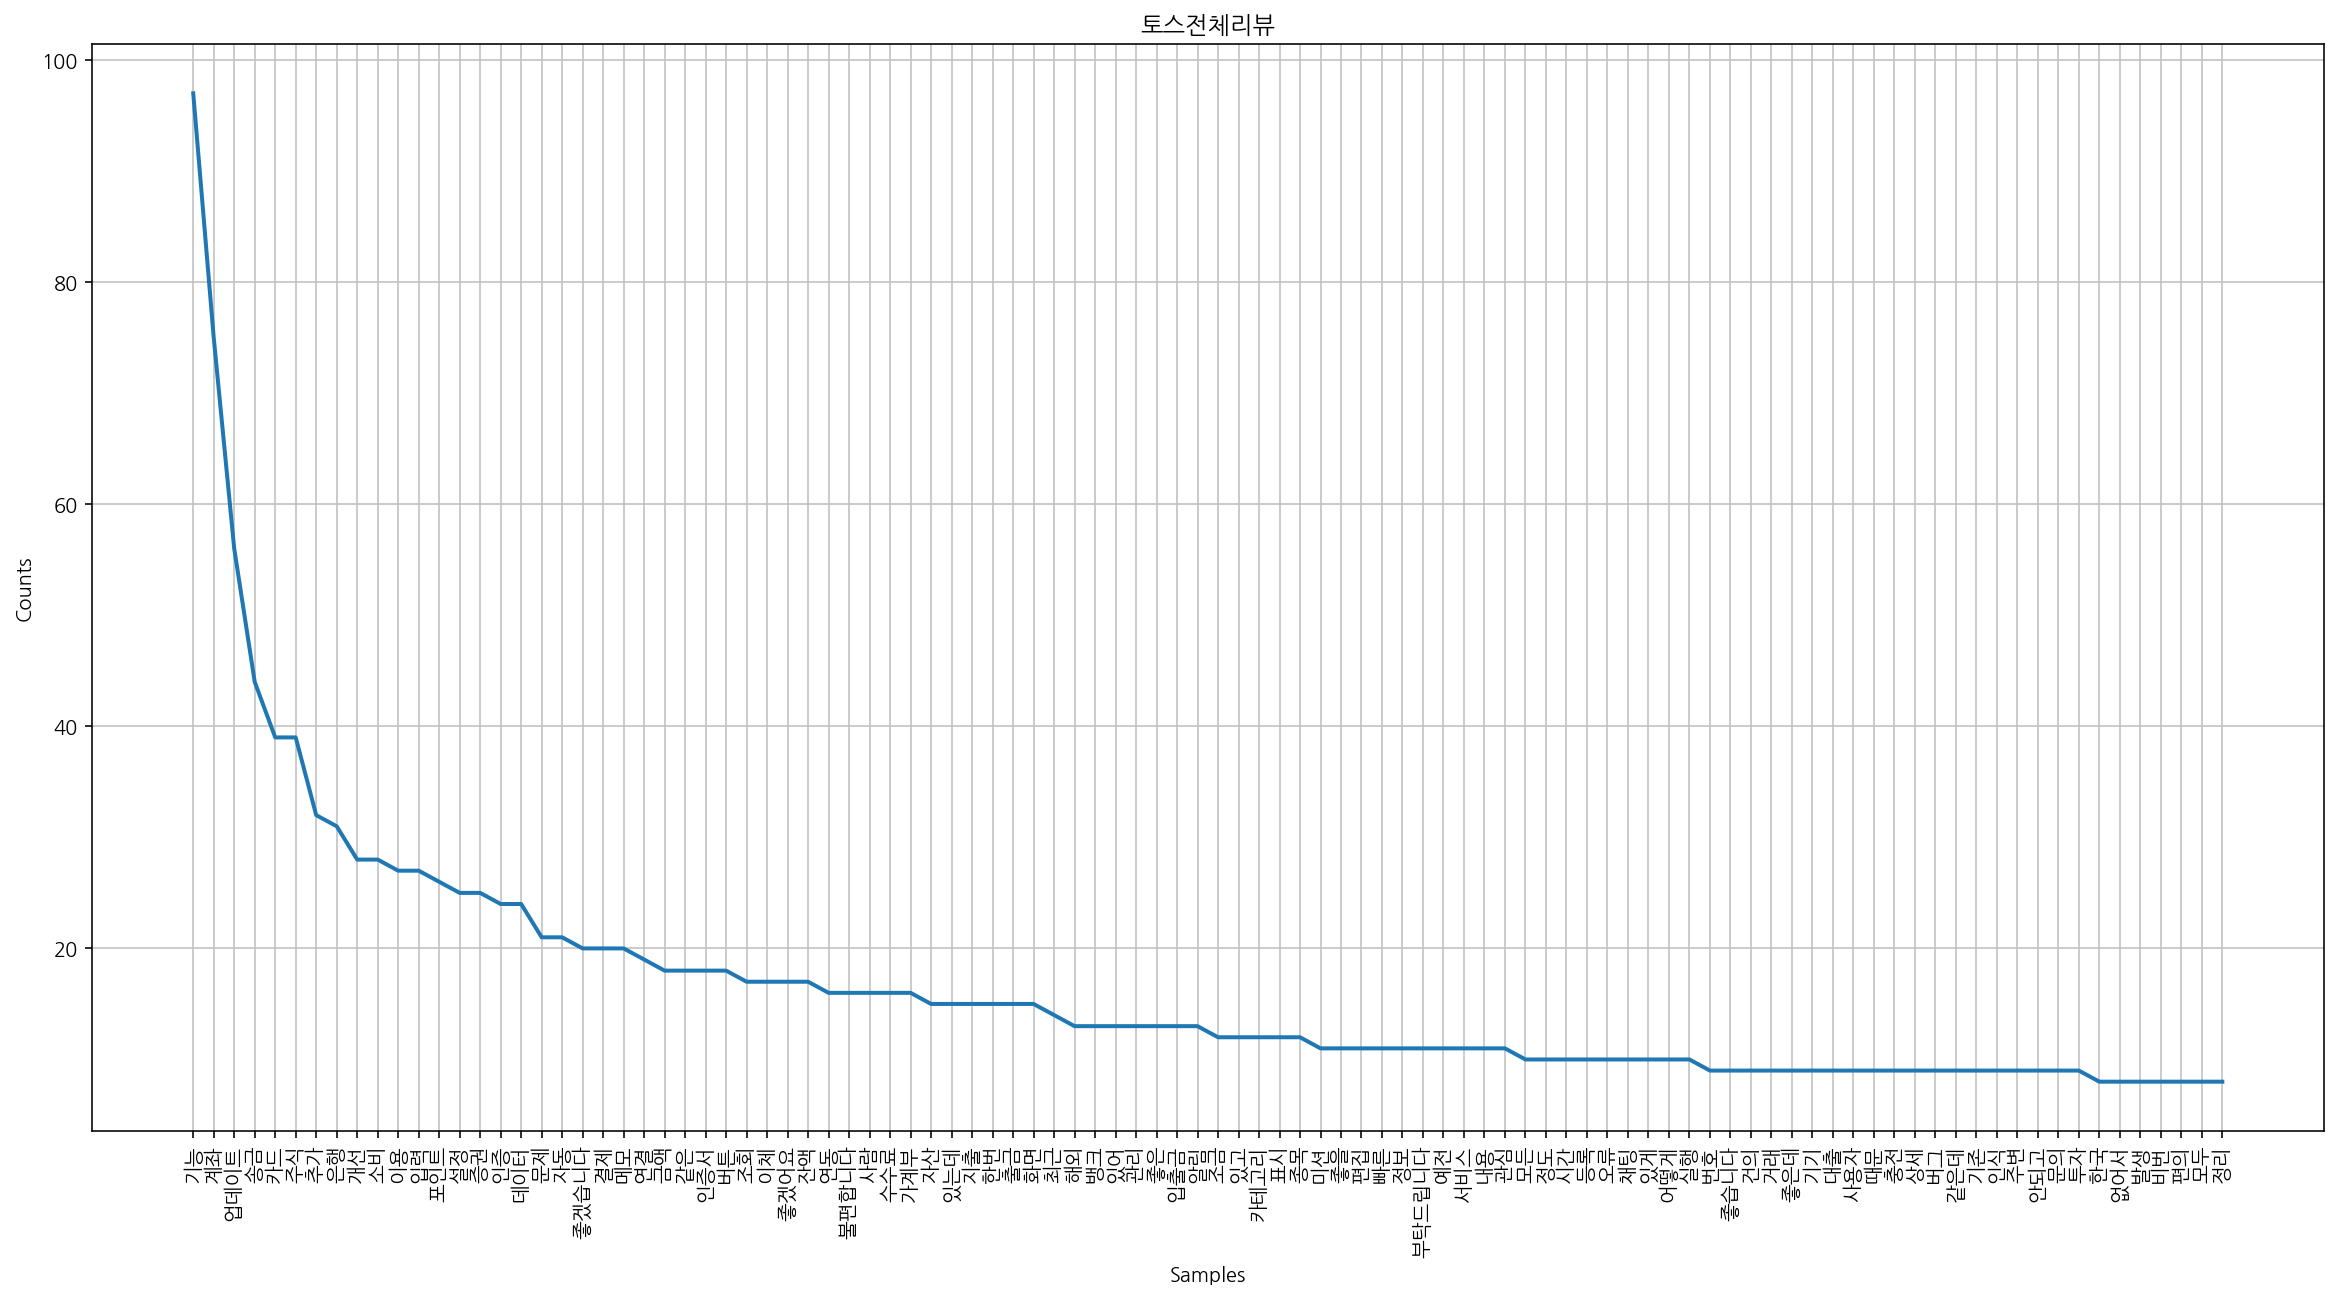

In [ ]:
kor = nltk.Text(title, name='단어 빈도수')
plt.figure(figsize=(20,10))
plt.title("토스전체리뷰")
kor.plot(100)
plt.show()

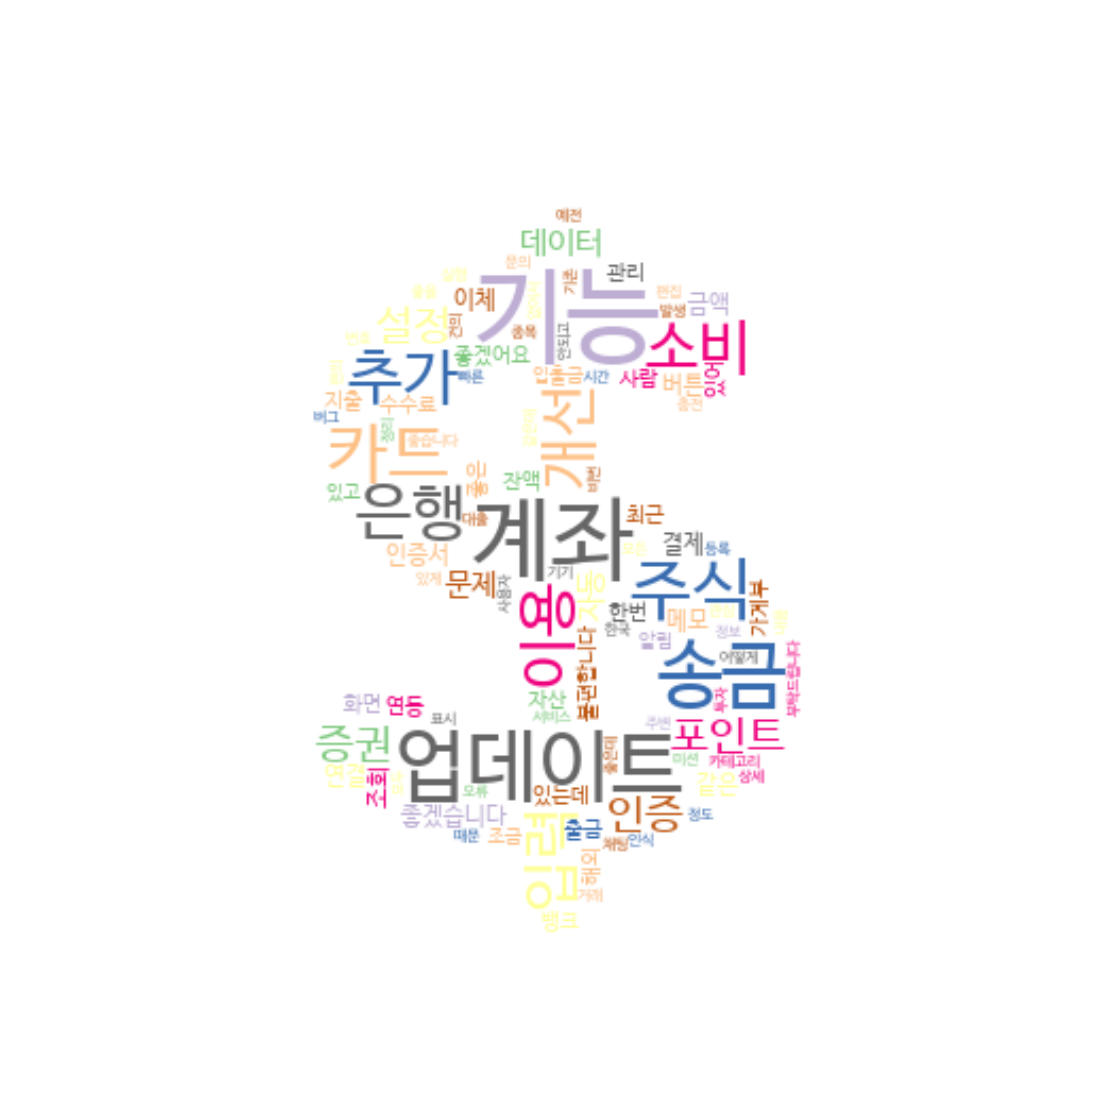

In [ ]:
text_cnt = Counter(kor) #워드클라우드를 만들기 전 불용어 제거한 단어들의 빈도수 저장
img_mask = np.array(Image.open("/content/drive/MyDrive/텍데분/wc.jpeg")) #이미지 설정

wordcloud = WordCloud(font_path = fontpath, 
                      background_color='white',
                      colormap = "Accent_r", 
                      mask = img_mask, 
                      random_state = 20, 
                      max_words = 100).generate_from_frequencies(text_cnt)

plt.figure(figsize = (10, 10))
plt.imshow(wordcloud, interpolation = "bilinear")        
plt.axis("off")

plt.savefig("toss.png")
plt.show()

In [ ]:
#documents을 받아서 문서 단어 행렬 만들기
def build_doc_term_mat(documents): 
    
    id2word = corpora.Dictionary(documents) #id2word : 토픽 모델링 딕셔너리
    corpus = [id2word.doc2bow(document) for document in documents] #corpus : 용어-문서 빈도

    return corpus, id2word 
    
    
#단어를 입력하면 단어가 여러 토픽에 해당될 수 있는데 각 토픽에서 갖는 가중치를 표시
def print_term_topics(term, dictionary, model):
    word_id = dictionary.token2id[term]   #단어의 아이디 구함
    print(model.get_term_topics(word_id))  

# 문서에 대한 토픽가중치를 반복하면서 전체 문서에 대해서 표시
def print_doc_topics(model, corpus): 
    
    for doc_num, doc in enumerate(corpus):
        topic_probs = model[doc]
        print("Doc num: {}".format(doc_num))

        for topic_id, prob in topic_probs:
            print("\t{}\t{}".format(topic_id, prob))
        
        if doc_num == 2:  # 시간 관계상 2번 문서까지만 출력, "0번문서, 1번문서, 2번문서"에 대해서만 해당문서의 토픽가중치를 표시                                     
            break

        print("\n")  

#모델링 후 각 토픽별로 중요한 단어들을 표시
def print_topic_words(model) : 
    for topic_id in range(NUM_TOPICS): 
        topic_word_probs = model.show_topic(topic_id, TOPICS_W_NUM)
        print("Topic ID: {}".format(topic_id))

        for topic_word, prob in topic_word_probs:
            print("\t{}\t{}".format(topic_word, prob))
        print("\n")

#LDA 시각화
def create_vis(model):
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim_models.prepare(model, corpus, id2word, sort_topics=False)
    pyLDAvis.save_html(vis, RESULT_SAVE_LDAVIS)
    return vis

In [ ]:
corpus, id2word = build_doc_term_mat(LL)
print(id2word.token2id) #단어들의 id표시
print(corpus[2][:5]) #예시

{'거기': 0, '모든': 1, '방법': 2, '번호': 3, '불가': 4, '안녕하세요': 5, '업데이트': 6, '없구요': 7, '없습니다': 8, '없어서': 9, '여태': 10, '이민': 11, '이용': 12, '인증': 13, '있을까요': 14, '있지만': 15, '잠시': 16, '전화번호': 17, '주식': 18, '카드': 19, '한국': 20, '해외': 21, '거리': 22, '다르게': 23, '다름이': 24, '불편하고': 25, '불편한': 26, '실제': 27, '아닌': 28, '이점': 29, '조금': 30, '좋습니다': 31, '개선': 32, '글자': 33, '기전': 34, '놨는데': 35, '도데': 36, '똑같은': 37, '리뷰': 38, '미션': 39, '분명히': 40, '아니고': 41, '완려': 42, '의문': 43, '일부러': 44, '있는지': 45, '자꾸': 46, '장난': 47, '정도': 48, '질도': 49, '컴퓨터': 50, '토시': 51, '하든': 52, '한글': 53, '건의': 54, '기능': 55, '마다': 56, '매번': 57, '발생': 58, '번거로워요': 59, '번거롭습니다': 60, '보안': 61, '보통': 62, '비번': 63, '송금': 64, '수순': 65, '시간': 66, '연장': 67, '이자': 68, '이해': 69, '좋을': 70, '편리하고': 71, '횟수': 72, '계좌': 73, '대로': 74, '더라도': 75, '문제': 76, '아쉬운게': 77, '없다든': 78, '연금': 79, '연금탭': 80, '원하는': 81, '위해': 82, '이용자': 83, '일반': 84, '자산': 85, '자유롭게': 86, '저축': 87, '투자탭': 88, '펀드': 89, '편의': 90, '편집': 91, '허용': 92, '가능한데': 93, '기별': 94, '모두': 95, 

In [ ]:
# Perplexity와 Coherence Score 을 판단
# Perplexity는 작을 수록 Coherence Score는 높을 수록 좋다.

TOPICS_W_NUM =10 #토픽 당 단어수는 10개
save_lda_model=0
UPDATE_EVERY = 1
CHUNKSIZE = 100
PASSES = 10

for i in range(1,30):
  NUM_TOPICS=i
 
  #해당 셀은 토픽모델링(LDA)에 대해 모델을 정의하는 셀
  lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, 
                                              num_topics=NUM_TOPICS, random_state=100, 
                                              update_every=UPDATE_EVERY, chunksize=CHUNKSIZE,
                                              passes=PASSES, alpha='auto', per_word_topics=True)

  doc_lda = lda_model[corpus]

  
  # Perplexity | Coherence Score
  coherence_model_lda = CoherenceModel(model=lda_model, texts=LL, dictionary=id2word, coherence='c_v')
  coherence_lda = coherence_model_lda.get_coherence()

  print('NUM_TOPICS',NUM_TOPICS,'Perplexity: ', lda_model.log_perplexity(corpus),'Coherence: ', coherence_lda)



NUM_TOPICS 1 Perplexity:  -7.060601889255185 Coherence:  0.30202677436604575
NUM_TOPICS 2 Perplexity:  -7.086849524064651 Coherence:  0.270336405675204
NUM_TOPICS 3 Perplexity:  -7.131684110913793 Coherence:  0.33793632128274415
NUM_TOPICS 4 Perplexity:  -7.207959328452272 Coherence:  0.3238951171764439
NUM_TOPICS 5 Perplexity:  -7.258335444604905 Coherence:  0.37669554761706453
NUM_TOPICS 6 Perplexity:  -7.279465471729401 Coherence:  0.3991637614989227
NUM_TOPICS 7 Perplexity:  -7.323815653636508 Coherence:  0.39751678754176334
NUM_TOPICS 8 Perplexity:  -7.348520679832954 Coherence:  0.43146892277532845
NUM_TOPICS 9 Perplexity:  -7.350629059300129 Coherence:  0.4129028994347923
NUM_TOPICS 10 Perplexity:  -7.372638991170507 Coherence:  0.41546121040785355
NUM_TOPICS 11 Perplexity:  -7.383842048909094 Coherence:  0.42048327296335103
NUM_TOPICS 12 Perplexity:  -7.418442720647118 Coherence:  0.3973580641363392
NUM_TOPICS 13 Perplexity:  -7.429866696091076 Coherence:  0.4036862983346316
NU

In [ ]:
print('토픽 기본 모델링을 실시 합니다. 해당 모델은 "lda_model" 변수로 입력됩니다.')
print(' ')

NUM_TOPICS = int(input('토픽의 개수를 입력해 주세요. ')) #8개
TOPICS_W_NUM = int(input('출력할 토픽별 단어의 개수를 입력해 주세요 ')) #10개
save_lda_model= int(input("선택한 토픽 모델을 저장하시겠습니까? \n0 저장  \n1 미저장  "))  #0 : 저장

UPDATE_EVERY = 1
CHUNKSIZE = 100
PASSES = 10

#lda 모델 정의
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, 
                                            num_topics=NUM_TOPICS, random_state=100, 
                                            update_every=UPDATE_EVERY, chunksize=CHUNKSIZE,
                                            passes=PASSES, alpha='auto', per_word_topics=True)

# 토픽 출력
pprint(lda_model.print_topics(num_words=TOPICS_W_NUM))
doc_lda = lda_model[corpus]

# 모델 저장 
if save_lda_model == 0:
    lda_model.save(LDA_MODEL_SAVE_NAME)

토픽 기본 모델링을 실시 합니다. 해당 모델은 "lda_model" 변수로 입력됩니다.
 
토픽의 개수를 입력해 주세요. 8
출력할 토픽별 단어의 개수를 입력해 주세요 10
선택한 토픽 모델을 저장하시겠습니까? 
0 저장  
1 미저장  0
[(0,
  '0.020*"이용" + 0.016*"카드" + 0.014*"연결" + 0.012*"출금" + 0.011*"계좌" + 0.011*"금액" '
  '+ 0.011*"업데이트" + 0.011*"인증" + 0.010*"채팅" + 0.008*"잔액"'),
 (1,
  '0.033*"업데이트" + 0.016*"문제" + 0.015*"자동" + 0.014*"카드" + 0.013*"미션" + '
  '0.013*"연결" + 0.012*"새로고침" + 0.011*"설치" + 0.009*"주문" + 0.009*"편하게"'),
 (2,
  '0.022*"자동" + 0.017*"포인트" + 0.017*"안되고" + 0.015*"결제" + 0.013*"업데이트" + '
  '0.011*"전화번호" + 0.011*"프라임" + 0.010*"서비스" + 0.010*"대화" + 0.009*"예전"'),
 (3,
  '0.029*"은행" + 0.022*"입출금" + 0.021*"인증서" + 0.019*"계좌" + 0.018*"이체" + '
  '0.015*"인증" + 0.012*"수수료" + 0.010*"조회" + 0.010*"발급" + 0.009*"수익"'),
 (4,
  '0.013*"배터리" + 0.011*"카메라" + 0.011*"위치" + 0.010*"주식" + 0.009*"해외" + '
  '0.009*"있어" + 0.009*"포인트" + 0.008*"없는" + 0.008*"실망" + 0.008*"개발"'),
 (5,
  '0.051*"기능" + 0.032*"계좌" + 0.027*"송금" + 0.019*"추가" + 0.016*"설정" + '
  '0.013*"가계부" + 0.012*"좋겠습니다" + 0.011*"메모" + 0.0

In [ ]:
# 토픽별 키워드 조회
print_topic_words(lda_model)

Topic ID: 0
	이용	0.019736861810088158
	카드	0.01617247797548771
	연결	0.013716709800064564
	출금	0.012303691357374191
	계좌	0.011434060521423817
	금액	0.010804311372339725
	업데이트	0.010765849612653255
	인증	0.010540180839598179
	채팅	0.009976115077733994
	잔액	0.008312826044857502


Topic ID: 1
	업데이트	0.033198677003383636
	문제	0.015902705490589142
	자동	0.015061228536069393
	카드	0.014260143972933292
	미션	0.013120490126311779
	연결	0.012584165669977665
	새로고침	0.012479733675718307
	설치	0.010758374817669392
	주문	0.009183785878121853
	편하게	0.008903381414711475


Topic ID: 2
	자동	0.022010410204529762
	포인트	0.01716514863073826
	안되고	0.016742227599024773
	결제	0.01485300250351429
	업데이트	0.012721149250864983
	전화번호	0.011038580909371376
	프라임	0.011038558557629585
	서비스	0.009865043684840202
	대화	0.009709875099360943
	예전	0.009312399663031101


Topic ID: 3
	은행	0.02907063066959381
	입출금	0.022054681554436684
	인증서	0.02125447988510132
	계좌	0.0185867790132761
	이체	0.01775808446109295
	인증	0.015373238362371922
	수수료	0.011767922900617123
	조회	0.01029

In [ ]:
"""
위의 셀에서 학습한 모델을 시각화 하여 HTML 파일로 저장하는 셀. 

"""

#lda_model or optimal_model
create_vis(lda_model)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.008276 -0.054984       1        1  17.680338
1     -0.043456  0.116098       2        1   9.804214
2     -0.074675  0.120393       3        1   9.540801
3      0.038818 -0.148151       4        1  11.318919
4     -0.034046 -0.041206       5        1   8.156052
5      0.231846  0.061024       6        1  26.521380
6     -0.039953  0.001584       7        1   6.420596
7     -0.086810 -0.054759       8        1  10.557700, topic_info=     Term       Freq      Total Category  logprob  loglift
55     기능  77.000000  77.000000  Default  30.0000  30.0000
98     은행  25.000000  25.000000  Default  29.0000  29.0000
128    자동  16.000000  16.000000  Default  28.0000  28.0000
6    업데이트  40.000000  40.000000  Default  27.0000  27.0000
64     송금  37.000000  37.000000  Default  26.0000  26.0000
..    ...        ...        ...      ...      ...      ...
295    최근   2.184853  11.996876   Topic8  -5.3690   0.5452
148    기기   1.984437   6.910158   Topic8  -5.4652   1.0007
12     이용   2.245407  21.108444   Topic8  -5.3417   0.0075
104    결제   2.170553  16.416207   Topic8  -5.3756   0.2250
64     송금   2.183047  37.668506   Topic8  -5.3698  -0.5998

[440 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
591       6  0.965766   가계부
872       5  0.548278   가까운
1378      2  0.458721    가능
1378      7  0.458721    가능
267       1  0.243784  가능하게
...     ...       ...   ...
642       3  0.184893    화면
642       4  0.092446    화면
642       7  0.554678    화면
324       2  0.684999    활용
324       4  0.228333    활용

[638 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8])